# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [2]:
import numpy as np
import os 
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này. 

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

In [2]:
import zipfile
# Giải nén file
zip_ref = zipfile.ZipFile("dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

In [2]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'dataset'
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
imagePaths = list(paths.list_images(dataset))
# Shuffle image path
#imagePaths = list(np.random.permutation(imagePaths))

In [4]:
imagePaths[:5]

['dataset/with_mask/7205.jpg',
 'dataset/with_mask/2626.jpg',
 'dataset/with_mask/11266.jpg',
 'dataset/with_mask/5246.jpg',
 'dataset/with_mask/5034.jpg']

<details><summary> Gợi ý </summary>

Sử dụng biến ```dataset```

</details>

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [5]:
import cv2
from deepface import DeepFace
# khởi tạo list rỗng: chứa các bức ảnh
data = [] 

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
for index, img_path in enumerate(imagePaths[:4000] + imagePaths[-4000:]):
    try:
    
        if index%1000 == 0:
            print(index)
        label = img_path.split(os.path.sep)[-2]
        # Chèn các dữ liệu nhãn vào list labels
        labels.append(label)
        # Sử dụng hàm load_img để tạo mảng chứa dữ liệu tấm ảnh với kích thước 224 x 224
        image = load_img(img_path, target_size=(224, 224))
        
        
        image = img_to_array(image)
        # Chèn các dữ liệu ảnh vào Wlist data
        data.append(image)
    except Exception as E: 
        pass
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data,dtype='float32')
labels = np.array(labels, dtype=str)

0
1000
2000
3000
4000
5000
6000
7000


<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [6]:
# In ra định dạng của tập dữ liệu data
data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn) 

In [7]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels, 2)

<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

In [8]:
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
X_train, X_test, y_train, y_test= train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, stratify = y_test, random_state = 0)

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [9]:
X_train.shape

(4000, 224, 224, 3)

In [10]:
y_train.shape

(4000, 2)

In [11]:
X_test.shape

(3200, 224, 224, 3)

In [12]:
y_test.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [13]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:

aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15, 
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')


<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

In [14]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
baseModel = EfficientNetB0(weights='imagenet',
                           include_top=False,
                           input_tensor=Input(shape=(224, 224, 3)))

2023-02-11 12:59:54.701087: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-02-11 12:59:54.715127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-02-11 12:59:54.715963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:89:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-02-11 12:59:54.716790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-02-11 12:59:54.717595: I tensorf

<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [15]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

In [16]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(units=128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet 

In [17]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
for layer in baseModel.layers:
    layer.trainable = False

<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

(128, 224, 224, 3)


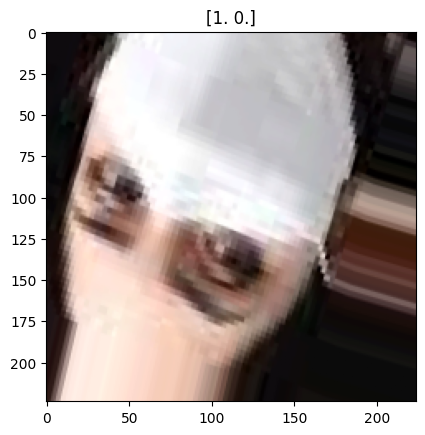

In [19]:
data_aug = aug.flow(X_train, y_train, batch_size = 128)
for x, y in data_aug:
    print(x.shape)
    index = 54
    plt.imshow(x[index]/255)
    plt.title(y[index])
    plt.show()
    break

In [19]:
## nếu đã huấn luyện model từ trước, ta dùng hàm load_model để load lại model
model = tf.keras.models.load_model("efficientnet.model")

In [20]:
learning_rate = 0.001
Epochs = 12
BS = 256 # batch size

# Khởi tạo thuật toán tối ưu Adam
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
decay = learning_rate/Epochs

# khai báo optimization Adam với tham số learning_rate và decay cho trước
opt = Adam(learning_rate=learning_rate, decay=decay)

# khai báo metrics
auc = tf.keras.metrics.AUC(curve='ROC')
# tính toán chi phí
losses = tf.keras.losses.BinaryCrossentropy()
# biên dịch model
model.compile(loss=losses, optimizer = opt, metrics = [auc, 'accuracy'])


# huấn luyện model
H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(X_train, y_train, batch_size = BS),
    steps_per_epoch = len(X_train)//BS,
    validation_data = (X_val, y_val),
    validation_steps = len(X_val)//BS,
    epochs = Epochs
)
# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet.model')

Epoch 1/12


2023-02-11 13:00:43.738667: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2023-02-11 13:00:46.139318: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2023-02-11 13:00:47.658734: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2023-02-11 13:00:47.985885: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


15/15 [==============================] - 378s 25s/step - loss: 0.2595 - auc: 0.9664 - accuracy: 0.8921 - val_loss: 0.0872 - val_auc: 0.9936 - val_accuracy: 0.9737
Epoch 2/12
15/15 [==============================] - 34s 2s/step - loss: 0.0905 - auc: 0.9942 - accuracy: 0.9685 - val_loss: 0.0622 - val_auc: 0.9950 - val_accuracy: 0.9850
Epoch 3/12
15/15 [==============================] - 34s 2s/step - loss: 0.0935 - auc: 0.9940 - accuracy: 0.9696 - val_loss: 0.0566 - val_auc: 0.9952 - val_accuracy: 0.9900
Epoch 4/12
15/15 [==============================] - 33s 2s/step - loss: 0.0782 - auc: 0.9955 - accuracy: 0.9714 - val_loss: 0.0475 - val_auc: 0.9966 - val_accuracy: 0.9862
Epoch 5/12
15/15 [==============================] - 35s 2s/step - loss: 0.0719 - auc: 0.9962 - accuracy: 0.9755 - val_loss: 0.0452 - val_auc: 0.9967 - val_accuracy: 0.9875
Epoch 6/12
15/15 [==============================] - 34s 2s/step - loss: 0.0540 - auc: 0.9978 - accuracy: 0.9818 - val_loss: 0.0369 - val_auc: 0.9968 

2023-02-11 13:15:51.746698: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


- In ra lịch sử huấn luyện của mô hình

In [23]:
H.history

{'loss': [0.2595260739326477,
  0.09048045426607132,
  0.0935422033071518,
  0.07818899303674698,
  0.07189611345529556,
  0.05395403131842613,
  0.06245154142379761,
  0.05397675558924675,
  0.05115947127342224,
  0.049411121755838394,
  0.03898174688220024,
  0.04545702412724495],
 'auc': [0.966442346572876,
  0.9941674470901489,
  0.9939793944358826,
  0.995511531829834,
  0.9962131381034851,
  0.9977810978889465,
  0.9972177743911743,
  0.9977174997329712,
  0.9981088638305664,
  0.9977779388427734,
  0.9988477826118469,
  0.9984343647956848],
 'accuracy': [0.8920940160751343,
  0.9684829115867615,
  0.9695512652397156,
  0.97142094373703,
  0.9755208492279053,
  0.9818376302719116,
  0.9791666865348816,
  0.9810363054275513,
  0.9823718070983887,
  0.9845085740089417,
  0.9866452813148499,
  0.9853098392486572],
 'val_loss': [0.08717869967222214,
  0.06215865910053253,
  0.0566081665456295,
  0.0475362166762352,
  0.045223139226436615,
  0.036937061697244644,
  0.03597231954336166

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

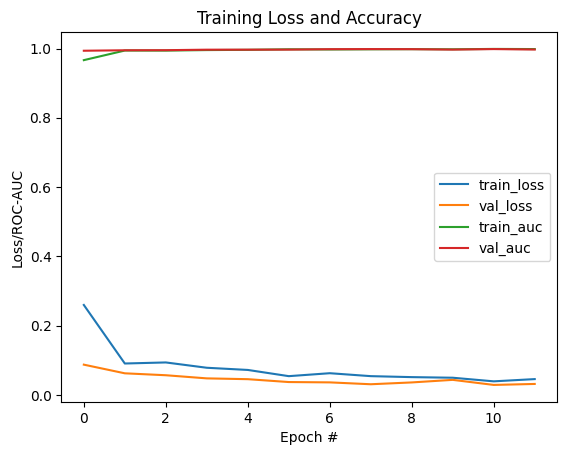

In [24]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [3]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

/data/thinhlv/thiennn/deeplearning/embedding/Asm1/align_faces.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/data/thinhlv/thiennn/deeplearning/embedding/Asm1/align_faces.py:184: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':
/data/thinhlv/data/anaconda/envs/tf-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

**Có thể học viên sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignemnt?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Học viên có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

In [4]:
detector = MtcnnDetector()

def face_detection(img, output_size, inner_padding=0.25, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""
    
    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)
    
    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = inner_padding
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)
            
            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)
               
    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)
                
    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [27]:
test_X_align = X_test.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

In [28]:
choose = []

for i in range(len(X_test)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        test_X_align[i] = face_detection(X_test[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue
        
choose = np.array(choose)

In [29]:
test_X_align.shape

(3200, 224, 224, 3)

In [30]:
choose[:10]

array([ 1,  2,  5,  6,  8, 10, 11, 12, 13, 15])

In [31]:
test_X_align[choose, :, :, :].shape

(1756, 224, 224, 3)

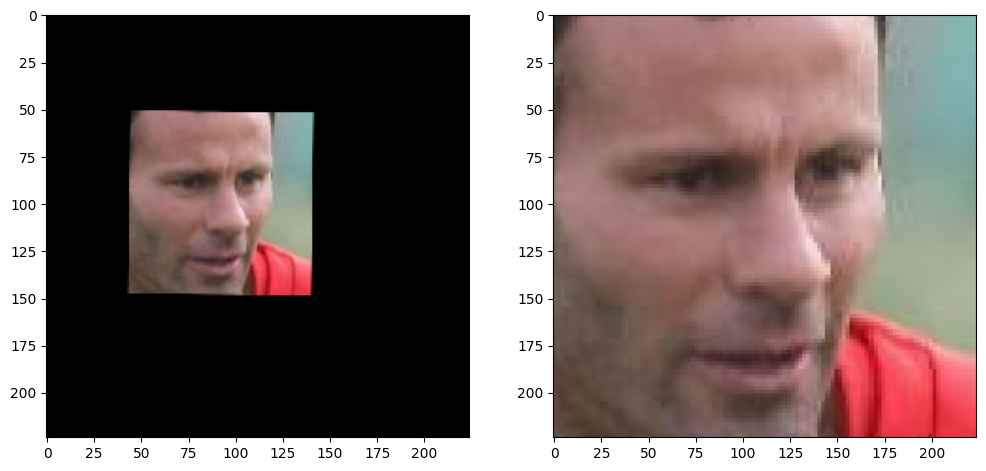

In [32]:
index = 15
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.imshow(test_X_align[index]/255)
plt.subplot(1, 2, 2)
plt.imshow(X_test[index]/255)
plt.show()

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [33]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [34]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
# predict with align
predict = model.predict(test_X_align[choose, :, :, :])
# lấy ra class có score cao nhất
predict = np.argmax(predict, axis = 1)
# tính auc score 
roc_auc_score(y_test[choose, :].argmax(axis=1), predict)

0.9622705018359853

In [35]:
predict = model.predict(X_test)
predict = np.argmax(predict, axis=1)
roc_auc_score(y_test.argmax(axis=1), predict)

0.9915624999999999

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [36]:
def mask_detect(image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

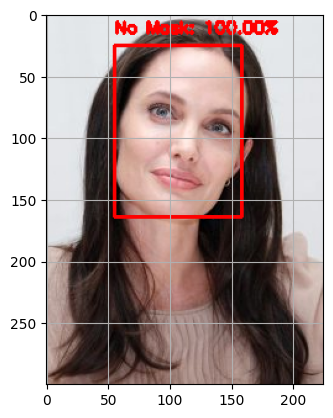

In [37]:
img = cv2.imread("image/angelina.jpg")
img = mask_detect(img)
# ::-1 mean convert BGR to RGB
plt.imshow(img[:, :, ::-1])
plt.grid(True)
plt.show()

In [ ]:
img = cv2.imread("image/angelina.jpg")
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(True)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

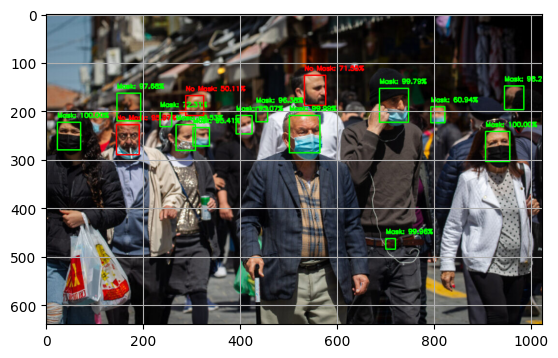

In [38]:
img = cv2.imread("image/people.jpg")
img = mask_detect(img)
# ::-1 mean convert BGR to RGB
plt.imshow(img[:, :, ::-1])
plt.grid(True)
plt.show()

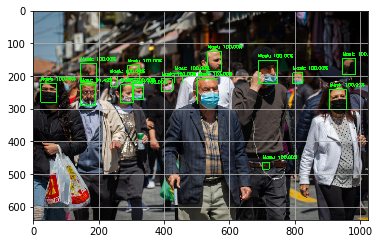

In [ ]:
img = cv2.imread("image/people.jpg")
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

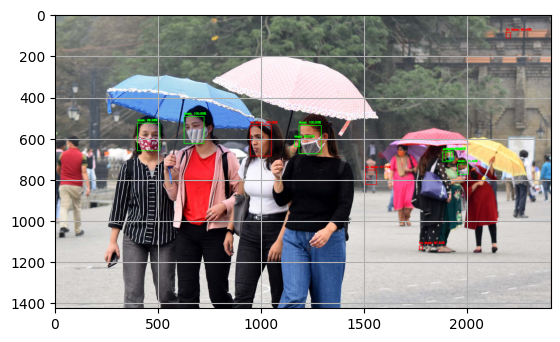

In [39]:
img = cv2.imread("image/woman.jpg")
img = mask_detect(img)
# ::-1 mean convert BGR to RGB
plt.imshow(img[:, :, ::-1])
plt.grid(True)
plt.show()

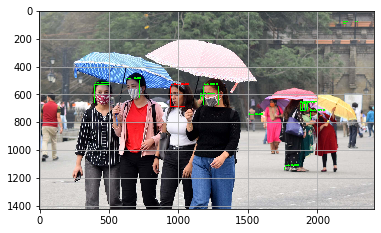

In [ ]:
img = cv2.imread("image/woman.jpg")
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

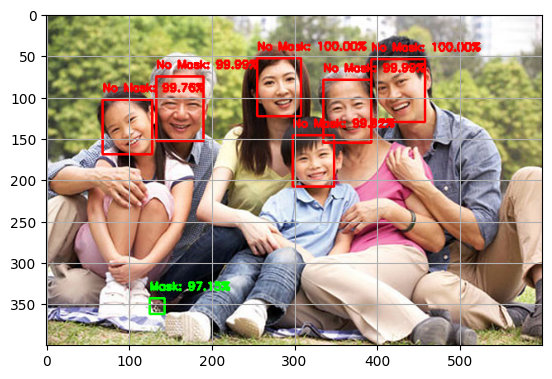

In [40]:
img = cv2.imread("image/family.jpg")
img = mask_detect(img)
# ::-1 mean convert BGR to RGB
plt.imshow(img[:, :, ::-1])
plt.grid(True)
plt.show()

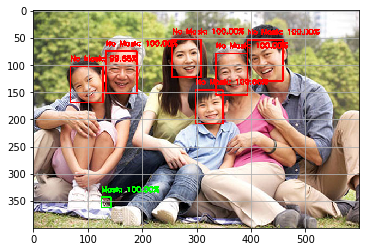

In [ ]:
img = cv2.imread("image/family.jpg")
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [39]:
from imutils.video import VideoStream
import imutils

In [ ]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

# 6. Cải thiện mô hình

- Phần này học viên sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment


Các bước cải thiện: 
1. Số lượng dữ liệu
    Ta cần thêm giữ liệu cho việc training, để model có thể khái quát hóa hơn
2. Chất lượng dữ liệu
    Vì dữ liệu khi training có những khuôn mặt rất xa và bao gồm cảnh vật xung quanh hoặc có nhiều khuôn mặt trong 1 hình,
    Vì vậy ta dùng các thuật toán phát hiện khuôn mặt, để cắt ra hình ảnh khuôn mặt
3. Model nhận diện đeo khẩu trang
    Model càng sâu thì thường có cho độ chính sác tốt hơn.
    Ta có thể sử dụng EfficientNetB1 - B7 hoặc ResNet 101, 151.
    Hoặc ta thêm 1 vài layer ở các lớp cuối (BatchNormalization, Dense 1024, 512, 256)
4. Cải thiện model phát hiện khuôn mặt
    Vì những ví dụ trên ta thấy rằng model có thể detect ra những vùng không phải là khuôn mặt
    Điều này ảnh hướng đến quá trình predict sẽ không chính xác    


### Building data

In [5]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:
import cv2
# khởi tạo list rỗng: chứa các bức ảnh
data = [] 

# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
for index, img_path in enumerate(imagePaths):
    try:
    
        if index%1000 == 0:
            print(index)

        # Sử dụng hàm load_img để tạo mảng chứa dữ liệu tấm ảnh với kích thước 224 x 224
        image = load_img(img_path, target_size=(224, 224))
        
        image = img_to_array(image)
        # Chèn các dữ liệu ảnh vào Wlist data
        data.append(image)
        
        label = img_path.split(os.path.sep)[-2]
        # Chèn các dữ liệu nhãn vào list labels
        labels.append(label)
    except Exception as E: 
        print(f"Unexpected {E=}, {type(E)=}")
        pass
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data,dtype='float32')
labels = np.array(labels, dtype=str)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [6]:
data.shape, labels.shape

((29080, 224, 224, 3), (29080,))

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels, 2)

In [8]:
X_train, X_test, y_train, y_test= train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, stratify = y_test, random_state = 0)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("X_test", X_test.shape)

X_train (14540, 224, 224, 3)
y_train (14540, 2)
X_val (2908, 224, 224, 3)
X_test (11632, 224, 224, 3)


### Building model

In [9]:
# khai báo hàm làm giàu dữ liệu 
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15, 
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest')

def base_model(input_shape, model):
    #%%
    if model == "EfficientNetB1":
        # khởi tạo EfficientNetB1
        base_model = tf.keras.applications.EfficientNetB1(input_tensor=Input(shape=input_shape),
                                                   include_top=False, 
                                                   weights='imagenet')

    elif model == "EfficientNetB3":
        # khởi tạo EfficientNetB3
        base_model = tf.keras.applications.EfficientNetB3(input_tensor=Input(shape=input_shape),
                                                include_top=False, 
                                                weights='imagenet')
    elif model == "EfficientNetB5":
        # khởi tạo EfficientNetB5
        base_model = tf.keras.applications.EfficientNetB5(input_tensor=Input(shape=input_shape),
                                                include_top=False, 
                                                weights='imagenet')
    elif model == "ResNet101":
        # khởi tạo ResNet101
        base_model = tf.keras.applications.ResNet101(input_tensor=Input(shape=input_shape),
                                                include_top=False, 
                                                weights='imagenet')

    elif model == "ResNet152":
        # khởi tạo ResNet152
        
        base_model = tf.keras.applications.ResNet152(input_tensor=Input(shape=input_shape),
                                                include_top=False, 
                                                weights='imagenet')

    else:
        # khởi tạo MobileNetV2
        base_model = tf.keras.applications.MobileNetV2(input_tensor=Input(shape=input_shape),
                                        include_top=False, 
                                        weights='imagenet')

    #%%
    print("building...")
    x = base_model.output
    # Thực hiện lớp pooling bằng cách sử dụng hàm trung bình trên các feature map của đầu ra của mô hình cơ sở.
    x = AveragePooling2D()(x)
    # Biến đổi tensor đầu ra từ lớp pooling thành vector bằng phẳng hóa (flatten).
    x = Flatten()(x)
    # Thêm một lớp fully connected với 128 node và hàm kích hoạt ReLU.
    x = Dense(units=1024, activation='relu')(x)
    # Thêm một lớp Dropout với tỷ lệ bỏ qua là 0.5 để giảm overfitting.
    x = Dropout(0.5)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs = base_model.input, outputs = x)
    for layer in base_model.layers:
        layer.trainable = False
    return model
    

In [11]:
model_EfficientNetB5 = base_model((224, 224, 3), "EfficientNetB5")
model_EfficientNetB5.summary()

building...
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
___________________________________________________________________________

(128, 224, 224, 3)


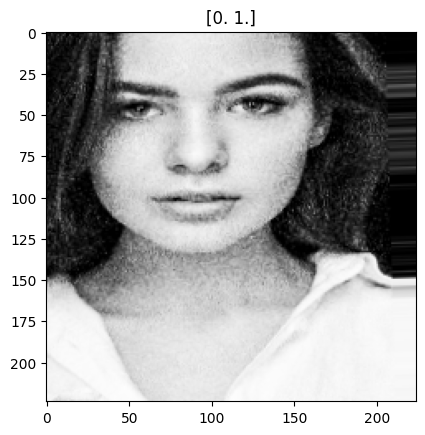

In [15]:
data_aug = aug.flow(X_train, y_train, batch_size = 128)
for x, y in data_aug:
    print(x.shape)
    index = 54
    plt.imshow(x[index]/255)
    plt.title(y[index])
    plt.show()
    break

### Training

In [16]:
def training_model(data, model_name, Epochs = 15, learning_rate=0.001, BS=512):
    model = base_model((224, 224, 3), model_name)
    X_train, y_train, X_val, y_val = data
    # Khởi tạo thuật toán tối ưu Adam
    decay = learning_rate/Epochs
    opt = Adam(learning_rate=learning_rate, decay=decay)

    auc = tf.keras.metrics.AUC(curve='ROC')
    losses = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=losses, optimizer = opt, metrics = [auc, 'accuracy'])

    # callback
    early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
    performance_sched = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)
    print(model_name+".h5")
    model_saver = tf.keras.callbacks.ModelCheckpoint(model_name+".h5", monitor='val_auc', save_best_only=True)

    H = model.fit(aug.flow(X_train, y_train, batch_size = BS),
            steps_per_epoch = len(X_train)//BS,
            validation_data = (X_val, y_val),
            validation_steps = len(X_val)//BS,
            epochs = Epochs,
            callbacks=[model_saver, early_stopper, performance_sched]
    )
    return H, model


In [21]:
data = (X_train, y_train, X_val, y_val)

<p> >= 0.992 </p>

In [16]:
H1, model_ResNet101 = training_model(data, "ResNet101")

building...
Epoch 1/15
28/28 [==============================] - 403s 14s/step - loss: 1.4563 - auc_1: 0.8837 - accuracy: 0.8533 - val_loss: 0.2161 - val_auc_1: 0.9846 - val_accuracy: 0.9780
Epoch 2/15
28/28 [==============================] - 141s 5s/step - loss: 0.5393 - auc_1: 0.9608 - accuracy: 0.9485 - val_loss: 0.1220 - val_auc_1: 0.9898 - val_accuracy: 0.9862
Epoch 3/15
28/28 [==============================] - 139s 5s/step - loss: 0.3937 - auc_1: 0.9704 - accuracy: 0.9584 - val_loss: 0.0695 - val_auc_1: 0.9950 - val_accuracy: 0.9887
Epoch 4/15
28/28 [==============================] - 138s 5s/step - loss: 0.2526 - auc_1: 0.9792 - accuracy: 0.9625 - val_loss: 0.0420 - val_auc_1: 0.9983 - val_accuracy: 0.9897
Epoch 5/15
28/28 [==============================] - 141s 5s/step - loss: 0.1427 - auc_1: 0.9892 - accuracy: 0.9674 - val_loss: 0.0400 - val_auc_1: 0.9988 - val_accuracy: 0.9911
Epoch 6/15
28/28 [==============================] - 136s 5s/step - loss: 0.0979 - auc_1: 0.9934 - accu

In [22]:
model_ResNet101.evaluate(X_test, y_test)

364/364 [==============================] - 183s 503ms/step - loss: 0.0245 - auc_1: 0.9995 - accuracy: 0.9930


[0.02450653165578842, 0.9994743466377258, 0.9929504990577698]

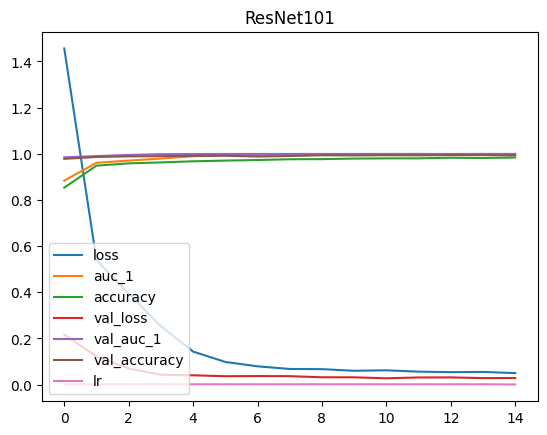

In [20]:
import pandas as pd
pd.DataFrame(H1.history).plot()
plt.title("ResNet101")
plt.show()

43941888/43941136 [==============================] - 11s 0us/step
building...
Epoch 1/15
28/28 [==============================] - 891s 32s/step - loss: 0.2278 - auc_3: 0.9783 - accuracy: 0.9278 - val_loss: 0.0366 - val_auc_3: 0.9984 - val_accuracy: 0.9866
Epoch 2/15
28/28 [==============================] - 132s 5s/step - loss: 0.0994 - auc_3: 0.9929 - accuracy: 0.9711 - val_loss: 0.0406 - val_auc_3: 0.9982 - val_accuracy: 0.9873
Epoch 3/15
28/28 [==============================] - 135s 5s/step - loss: 0.0745 - auc_3: 0.9952 - accuracy: 0.9756 - val_loss: 0.0284 - val_auc_3: 0.9992 - val_accuracy: 0.9907
Epoch 4/15
28/28 [==============================] - 132s 5s/step - loss: 0.0591 - auc_3: 0.9971 - accuracy: 0.9800 - val_loss: 0.0282 - val_auc_3: 0.9992 - val_accuracy: 0.9917
Epoch 5/15
28/28 [==============================] - 136s 5s/step - loss: 0.0508 - auc_3: 0.9976 - accuracy: 0.9832 - val_loss: 0.0214 - val_auc_3: 0.9994 - val_accuracy: 0.9914
Epoch 6/15
28/28 [==================

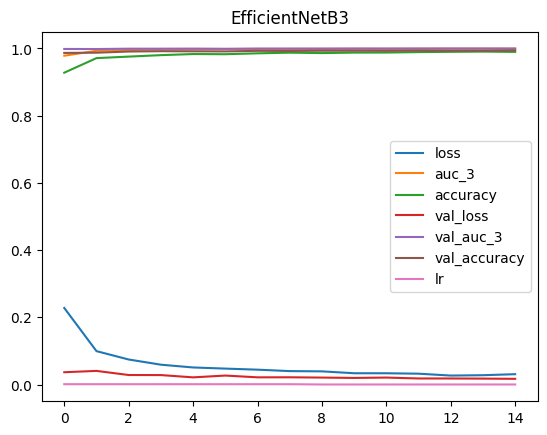

In [25]:
H3, model_EfficientNetB3 = training_model(data, "EfficientNetB3")
pd.DataFrame(H3.history).plot()
plt.title("EfficientNetB3")
plt.show()

building...
ResNet152.h5
Epoch 1/15
28/28 [==============================] - 440s 16s/step - loss: 1.3500 - auc_3: 0.8917 - accuracy: 0.8633 - val_loss: 0.1929 - val_auc_3: 0.9860 - val_accuracy: 0.9814
Epoch 2/15
28/28 [==============================] - 144s 5s/step - loss: 0.5502 - auc_3: 0.9594 - accuracy: 0.9500 - val_loss: 0.1621 - val_auc_3: 0.9876 - val_accuracy: 0.9807
Epoch 3/15
28/28 [==============================] - 143s 5s/step - loss: 0.3240 - auc_3: 0.9742 - accuracy: 0.9609 - val_loss: 0.0646 - val_auc_3: 0.9964 - val_accuracy: 0.9835
Epoch 4/15
28/28 [==============================] - 147s 5s/step - loss: 0.1976 - auc_3: 0.9841 - accuracy: 0.9632 - val_loss: 0.0431 - val_auc_3: 0.9977 - val_accuracy: 0.9883
Epoch 5/15
28/28 [==============================] - 146s 5s/step - loss: 0.1181 - auc_3: 0.9910 - accuracy: 0.9692 - val_loss: 0.0355 - val_auc_3: 0.9991 - val_accuracy: 0.9880
Epoch 6/15
28/28 [==============================] - 146s 5s/step - loss: 0.0931 - auc_3: 

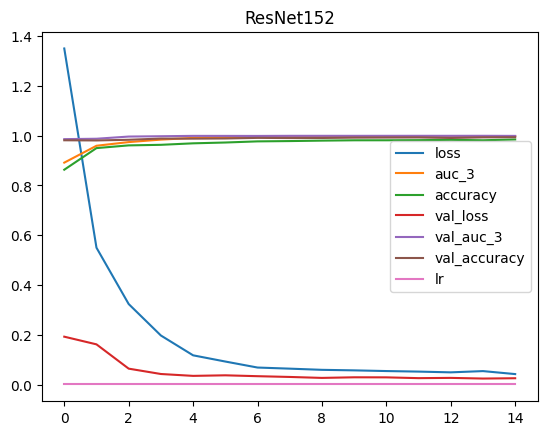

In [25]:
import pandas as pd
H3, model_ResNet152 = training_model(data, "ResNet152", BS=512)
pd.DataFrame(H3.history).plot()
plt.title("ResNet152")
plt.show()
model_ResNet152.save("model_ResNet152.h5")

### Evaluate model

#### Prepare

<p>Change face detector</p>
<p> I choose SSD because it has Average Precision higher than others. </p>

<a href="https://learnopencv.com/what-is-face-detection-the-ultimate-guide/#SSD-(Dec-2015)"> https://learnopencv.com/what-is-face-detection-the-ultimate-guide/#SSD-(Dec-2015) </a>

In [26]:
import tensorflow as tf
import face_recognition as face
def face_detection_ssd(img_detect, img_shape):
    h, w = img_shape
    locations_faces = face.face_locations(img_detect, model="ssd")
    for index, current_face in enumerate(locations_faces):
        top, right, bottom, left = current_face
        face_image = img_detect[top:bottom, left:right]
        face_image = tf.image.resize_with_pad(face_image, h, w, antialias=True)
        #face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
    return face_image


In [28]:
def get_detection_face(X_test, detector):
    choose = []
    for i in range(len(X_test)):
        try:
            # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
            ## Yêu cầu 11:
            ## VIẾT CODE Ở ĐÂY:
            if detector=="mtcnn":
                test_X_align[i] = face_detection(X_test[i].astype('uint8'), (224, 224), inner_padding=0.1, align = True)
            elif detector == "ssd":
                img = face_detection_ssd(X_test[i].astype('uint8'), (224, 224))
            else:
                return "detector is mtcnn or ssd"
            # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
            choose.append(i)
            
            if i % 2000 == 0:
                print("Index: ", i)
                print(len(choose))
        except:
            # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
            continue
            
    choose = np.array(choose)
    return choose

In [29]:
test_X_align = X_test.copy()
# Mtcnn detector
choose = get_detection_face(test_X_align, "mtcnn")
# Ssd detector
choose1 = get_detection_face(test_X_align, "ssd")

Index:  2000
1053
Index:  4000
2145
Index:  6000
3241
Index:  8000
4327
Index:  10000
5438
Index:  2000
1063
Index:  4000
2148
Index:  8000
4291
Index:  10000
5377


In [30]:
choose.shape, choose1.shape

((6333,), (6265,))

In [56]:
## Loading model
model_ResNet101 = tf.keras.models.load_model("ResNet101.model")
model_EfficientNetB3 = tf.keras.models.load_model("EfficientNetB3.model")
model_ResNet152 = tf.keras.models.load_model("ResNet152.h5")

In [31]:
from sklearn.metrics import roc_auc_score
def evaluate_model(model, test_X_align, y_test, choose):
    print("Alignment")
    print(test_X_align[choose, :, :, :].shape)
    evaluate = model.evaluate(test_X_align[choose, :, :, :], y_test[choose, :])
    print("Loss: ", evaluate[0])
    print("AUC: ", evaluate[1])
    print("Accuracy: ", evaluate[2])
    predict = model.predict(test_X_align[choose, :, :, :])
    print("roc_auc_score: ", roc_auc_score(y_test[choose, :], predict))
    
    print("No Alignment")
    print(test_X_align.shape)
    evaluate1 = model.evaluate(test_X_align, y_test)
    print("Loss: ", evaluate1[0])
    print("AUC: ", evaluate1[1])
    print("Accuracy: ", evaluate1[2])
    predict = model.predict(test_X_align)
    print("roc_auc_score: ", roc_auc_score(y_test, predict))

#### Evaluating with MTCNN face detector


    Ta có thể thấy AUC score sử dụng model.evaluate cho ra kết quả khác với roc_auc_score, bởi vì kết quả của model.evaluate là trung bình AUC score theo batch size. Đối với roc_auc_score ta tính AUC dựa vào predict function (predict tất cả sample không theo batch size), sau đó sử dụng roc_auc_score để tính AUC score vì vậy mới có sự khác biệt.


In [63]:
## Evaluating ResNet101
evaluate_model(model_ResNet101, test_X_align, y_test, choose)

Alignment
(6333, 224, 224, 3)
198/198 [==============================] - 30s 151ms/step - loss: 0.0580 - auc_1: 0.9976 - accuracy: 0.9781
Loss:  0.05798465758562088
AUC:  0.9976149797439575
Accuracy:  0.978051483631134
roc_auc_score:  0.9966300593406154
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 56s 155ms/step - loss: 0.0459 - auc_1: 0.9985 - accuracy: 0.9840
Loss:  0.04590301215648651
AUC:  0.9985296726226807
Accuracy:  0.9840096235275269
roc_auc_score:  0.9988202991916388


In [64]:
evaluate_model(model_EfficientNetB3, test_X_align, y_test, choose)

Alignment
(6333, 224, 224, 3)
198/198 [==============================] - 22s 111ms/step - loss: 0.0711 - auc_3: 0.9966 - accuracy: 0.9806
Loss:  0.07110556960105896
AUC:  0.9965981841087341
Accuracy:  0.9805779457092285
roc_auc_score:  0.9943610111281149
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 41s 112ms/step - loss: 0.0471 - auc_3: 0.9984 - accuracy: 0.9867
Loss:  0.04710453748703003
AUC:  0.9983610510826111
Accuracy:  0.9866746664047241
roc_auc_score:  0.9984540893116298


    Có thể thấy rằng các mạng càng sâu cho accuracy càng cao

In [66]:
evaluate_model(model_ResNet152, test_X_align, y_test, choose)

Alignment
(6333, 224, 224, 3)
198/198 [==============================] - 42s 213ms/step - loss: 0.0550 - auc_4: 0.9972 - accuracy: 0.9823
Loss:  0.05497867614030838
AUC:  0.9971864223480225
Accuracy:  0.9823148846626282
roc_auc_score:  0.9954059190529324
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 80s 221ms/step - loss: 0.0430 - auc_4: 0.9983 - accuracy: 0.9874
Loss:  0.042992912232875824
AUC:  0.9982786178588867
Accuracy:  0.9874483942985535
roc_auc_score:  0.9985083289390217


#### Evaluating with SSD face detector

In [59]:
## Evaluating ResNet101
evaluate_model(model_ResNet101, test_X_align, y_test, choose1)

Alignment
(6315, 224, 224, 3)
198/198 [==============================] - 199s 1s/step - loss: 0.0336 - auc_1: 0.9988 - accuracy: 0.9888
Loss:  0.03355255350470543
AUC:  0.9988368153572083
Accuracy:  0.9887569546699524
roc_auc_score:  0.998096899706058
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 265s 729ms/step - loss: 0.0459 - auc_1: 0.9985 - accuracy: 0.9840
Loss:  0.04590301215648651
AUC:  0.9985296726226807
Accuracy:  0.9840096235275269
roc_auc_score:  0.9988202991916388


In [60]:
## Evaluating EfficientNetB3
evaluate_model(model_EfficientNetB3, test_X_align, y_test, choose1)

Alignment
(6315, 224, 224, 3)
198/198 [==============================] - 539s 3s/step - loss: 0.0567 - auc_3: 0.9977 - accuracy: 0.9867
Loss:  0.05665687099099159
AUC:  0.9977167844772339
Accuracy:  0.9866983294487
roc_auc_score:  0.9951708471554547
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 505s 1s/step - loss: 0.0471 - auc_3: 0.9984 - accuracy: 0.9867
Loss:  0.04710453748703003
AUC:  0.9983610510826111
Accuracy:  0.9866746664047241
roc_auc_score:  0.9984540893116298


In [32]:
## Evaluating ResNet152
evaluate_model(model_ResNet152, test_X_align, y_test, choose1)

Alignment
(6265, 224, 224, 3)
196/196 [==============================] - 229s 1s/step - loss: 0.0277 - auc_3: 0.9985 - accuracy: 0.9941
Loss:  0.027728063985705376
AUC:  0.9984719157218933
Accuracy:  0.99409419298172
roc_auc_score:  0.9982234473577487
No Alignment
(11632, 224, 224, 3)
364/364 [==============================] - 300s 824ms/step - loss: 0.0407 - auc_3: 0.9983 - accuracy: 0.9872
Loss:  0.040689073503017426
AUC:  0.9982784390449524
Accuracy:  0.9871904850006104
roc_auc_score:  0.9989997083271059


In [33]:
def mask_detect_ssd(model, image):
    
    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)
        
    return img

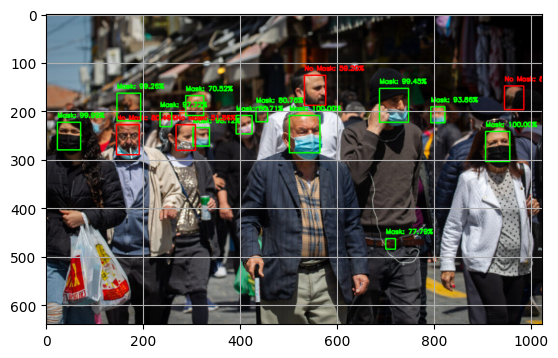

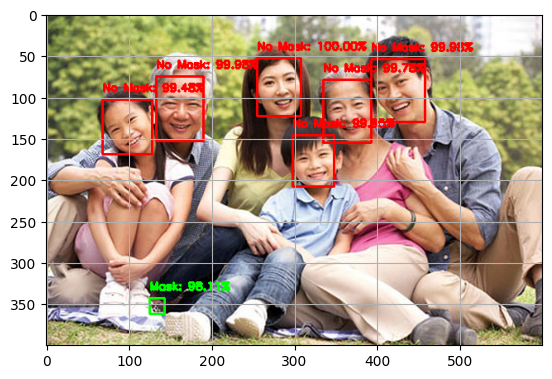

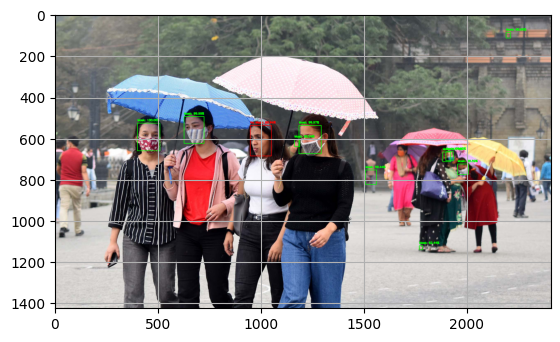

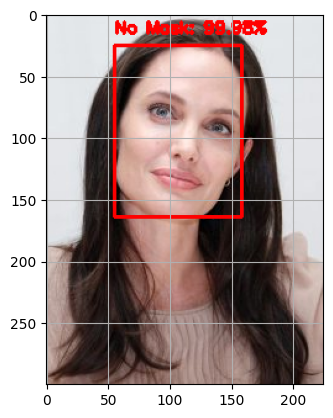

In [87]:
import glob
img_list = glob.glob("image/*.jpg")
for img_path in img_list:
    img = cv2.imread(img_path)
    img = mask_detect_ssd(model_EfficientNetB3, img)
    plt.imshow(img[:, :, ::-1])
    plt.grid(True)
    plt.show()

In [88]:
for img_path in img_list:
    img = cv2.imread(img_path)
    img = mask_detect_ssd(model_ResNet101, img)
    plt.imshow(img[:, :, ::-1])
    plt.grid(True)
    plt.show()

In [ ]:
for img_path in img_list:
    img = cv2.imread(img_path)
    img = mask_detect_ssd(model_ResNet152, img)
    plt.imshow(img[:, :, ::-1])
    plt.grid(True)
    plt.show()